### Imports

In [87]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
import torchvision


torch.cuda.is_available()

True

### Dataset splits

In [88]:
celeba_train = torchvision.datasets.CelebA(root="data/", split="train", target_type='identity', download=True, transform=torchvision.transforms.ToTensor())
celeba_valid = torchvision.datasets.CelebA(root="data/", split="valid", target_type='identity', download=True, transform=torchvision.transforms.ToTensor())
celeba_test = torchvision.datasets.CelebA(root="data/", split="test", target_type='identity', download=True, transform=torchvision.transforms.ToTensor())

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Data cleaning

In [89]:
# CelebA data cleaning: https://github.com/C3Imaging/Deep-Learning-Techniques/tree/clean-celebA

celeba_identity_clean = np.zeros(len(celeba_train)+len(celeba_valid)+len(celeba_test), dtype=int)
with open("data/celeba/clean_CelebA_v1_img_list.txt", "r") as f:
    for line in f:
        identity, idx = line.split("/")
        celeba_identity_clean[int(idx[:-5])-1] = int(identity)

In [90]:
different = (1 - sum(celeba_train.identity.numpy().squeeze() == celeba_identity_clean[:len(celeba_train)]) / len(celeba_train))*100
deleted = (sum(celeba_identity_clean == 0) / len(celeba_train)) * 100
print(f"{round(deleted, 3)}% identities of deleted, {round(deleted-different, 3)}% identities of changed")

3.147% identities of deleted, 0.496% identities of changed


In [91]:
with open("data/celeba/deleted_CelebA_v1_img_list.txt", "r") as f:
    for line in f:
        identity, filename = line.split("/")
        idx = int(filename[:-5])-1
        if (idx < len(celeba_train) and celeba_train.identity[idx] != int(identity)) or celeba_identity_clean[idx] != 0:
            print("Error")
            break
    else: print("Verified changed and deleted identities")

Verified changed and deleted identities


In [92]:
# train_filter_identities = []
# val_filter_identities = [1298]

Blurry: 8362, 940
Eyeglasses: 10521, 1383


Wearing_Hat: 8039, 940


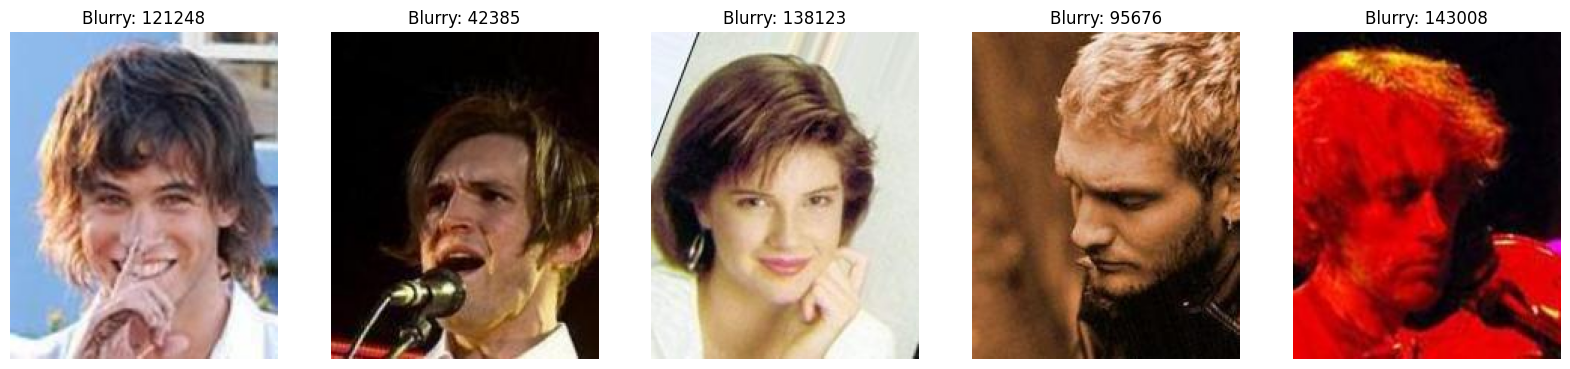

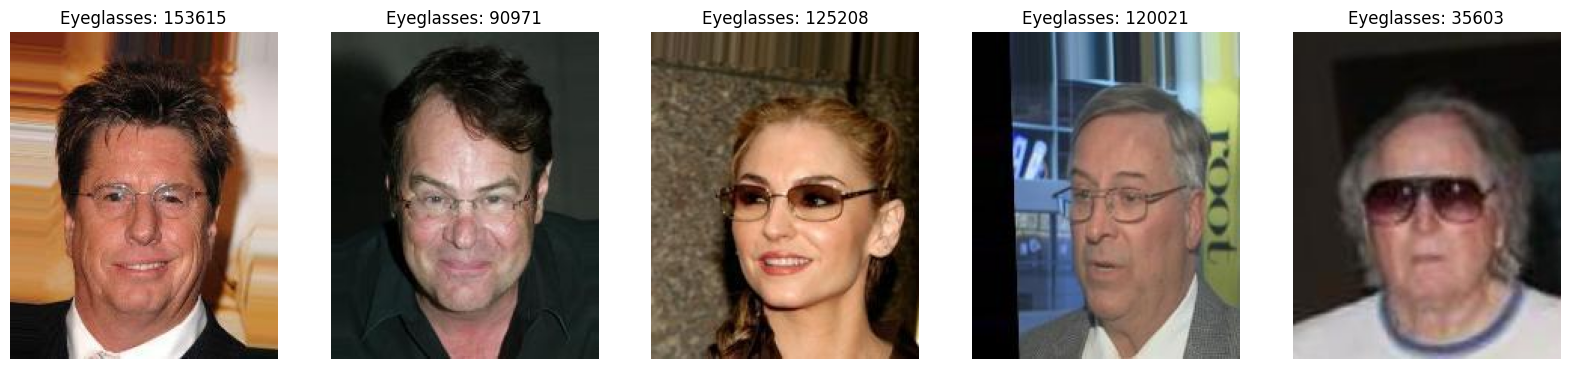

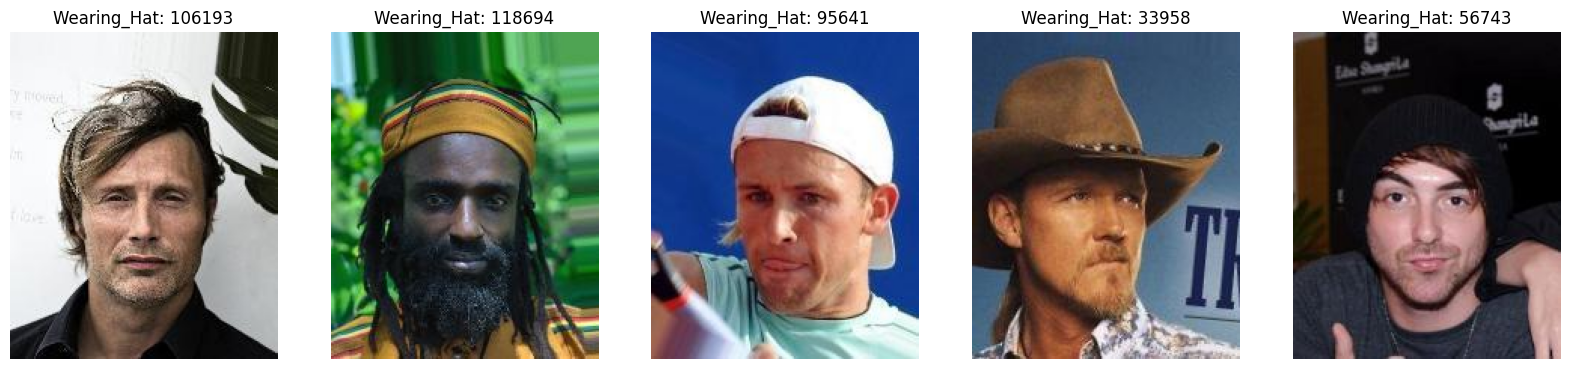

In [93]:
def show_with_attr(attr, has_attr, columns=5):
    train_idx = np.where(celeba_train.attr[:, attr] == has_attr)[0]
    valid_idx = np.where(celeba_valid.attr[:, attr] == has_attr)[0]
    attr_name = celeba_train.attr_names[attr]
    print(f"{attr_name}: {train_idx.shape[0]}, {valid_idx.shape[0]}")
    fig, ax = plt.subplots(1, columns, figsize=(20, 10))
    for i in range(columns):
        rnd = np.random.randint(0, train_idx.shape[0]-columns)
        rnd_idx = train_idx[rnd+i]
        ax[i].imshow(celeba_train[rnd_idx][0].permute(1, 2, 0))
        ax[i].set_title(f"{attr_name}: {rnd_idx}")
        ax[i].axis("off")
    

show_with_attr(10, True)
show_with_attr(15, True)
show_with_attr(35, True)

In [94]:
def filter_attr(attr):
    all_attr = np.concatenate((celeba_train.attr, celeba_valid.attr, celeba_test.attr))
    has_attr = all_attr[:, attr] == 1
    val_start = len(celeba_train)
    test_start = val_start+len(celeba_valid)
    
    # count how many are set to 0 from each set, that wasn't already 0 in celeba_identity_clean
    train_removed = sum(has_attr[:val_start] & (celeba_identity_clean[:val_start] != 0))
    valid_removed = sum(has_attr[val_start:test_start] & (celeba_identity_clean[val_start:test_start] != 0))
    test_removed = sum(has_attr[test_start:] & (celeba_identity_clean[test_start:] != 0))
    celeba_identity_clean[has_attr] = 0

    print(f"Removing all with attribute '{celeba_train.attr_names[attr]}'")
    print(f" Removed from train: {train_removed} ({sum(has_attr[:val_start])})")
    print(f" Removed from valid: {valid_removed} ({sum(has_attr[val_start:test_start])})")
    print(f" Removed from test: {test_removed} ({sum(has_attr[test_start:])})")
    print(f" Total removed: {train_removed + valid_removed + test_removed} ({sum(has_attr)})")
    print()

filter_attr(10)
filter_attr(35)

Removing all with attribute 'Blurry'
 Removed from train: 7934 (8362)
 Removed from valid: 904 (940)
 Removed from test: 981 (1010)
 Total removed: 9819 (10312)

Removing all with attribute 'Wearing_Hat'
 Removed from train: 7358 (8039)
 Removed from valid: 859 (940)
 Removed from test: 770 (839)
 Total removed: 8987 (9818)



In [95]:
train_left = sum(celeba_identity_clean[:len(celeba_train)] != 0)
valid_left = sum(celeba_identity_clean[len(celeba_train):len(celeba_train)+len(celeba_valid)] != 0)
test_left = sum(celeba_identity_clean[len(celeba_train)+len(celeba_valid):] != 0)
print(f"Train samples left: {train_left}, from {len(celeba_train)} ({train_left - len(celeba_train)})")
print(f"Valid samples left: {valid_left}, from {len(celeba_valid)} ({valid_left - len(celeba_valid)})")
print(f"Test samples left: {test_left}, from {len(celeba_test)} ({test_left - len(celeba_test)})")

Train samples left: 143164, from 162770 (-19606)
Valid samples left: 17653, from 19867 (-2214)
Test samples left: 17854, from 19962 (-2108)


### Triplet Sampler and Dataset

In [96]:
# Custom sampler class that generates batches with of triplets of images
class TripletSampler(torch.utils.data.sampler.Sampler):
    def __init__(self, dataset):
        self.dataset = dataset
        self.identity_array = self.create_identity_array(dataset)

    def __getitem__(self, i):
        # Get a random anchor image and its identity
        _, anchor_identity = self.dataset[i]
        # Get all indexes with the same identity
        same_identity_idx = self.identity_array[anchor_identity]
        # remove the anchor image from the list
        same_identity_idx = same_identity_idx[same_identity_idx != i]
        if len(same_identity_idx) == 0: return None
        # Get a random positive image
        positive_idx = same_identity_idx[np.random.randint(len(same_identity_idx))]
        # Get random index with different identity
        negative_idx = np.random.randint(len(self.dataset))
        while self.dataset.identity[negative_idx] == anchor_identity:
            negative_idx = np.random.randint(len(self.dataset))

        return (i, positive_idx, negative_idx)

    def __iter__(self):
        for i in range(len(self.dataset)):
            next_triple = self[i]
            if next_triple is None: continue
            yield next_triple

    def __len__(self):
        return len(self.dataset)

    def create_identity_array(self, dataset):
        # Create array where identity is the index to an array of all indexes of images of that identity
        identity_array = np.empty(max(dataset.identity)+1, dtype=object)
        for i, id in enumerate(dataset.identity):
            if identity_array[id] is None:
                identity_array[id] = np.array([i])
            else:
                identity_array[id] = np.append(identity_array[id], i)
                
        return identity_array

    def filter_identity_array(self, dataset, identity_array):
        # TODO
        for i, id in enumerate(dataset.identity):
            if id not in identity_array:
                identity_array[id] = None

        return identity_array




class TripletDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, triplet_idx):
        anchor_idx, positive_idx, negative_idx = triplet_idx
        a_img, a_label = self.dataset[anchor_idx]
        p_img, p_label = self.dataset[positive_idx]
        n_img, n_label = self.dataset[negative_idx]
        assert a_label == p_label and a_label != n_label, "Error in triplet dataset"
        return nn.Tensor(a_img, p_img, n_img), (a_label.item(), p_label.item(), n_label.item())

    def __len__(self):
        return len(self.dataset)


train_triplet_sampler = TripletSampler(celeba_train)
train_triplet_dataset = TripletDataset(celeba_train)
train_triplet_dl = torch.utils.data.DataLoader(train_triplet_dataset,
                                               batch_size=16,
                                               #shuffle=False, # Should be True later
                                               num_workers=0, # Needs to be 0 for me or calling iter never returns
                                               sampler=train_triplet_sampler,
                                               )

val_triplet_sampler = TripletSampler(celeba_valid)
val_triplet_dataset = TripletDataset(celeba_valid)
val_triplet_dl = torch.utils.data.DataLoader(val_triplet_dataset,
                                             batch_size=64,
                                             shuffle=False,
                                             num_workers=0, # Needs to be 0 for me or calling iter never returns
                                             sampler=val_triplet_sampler,
                                             )


### Triplet examples and inspecting the data

In [97]:
def plot_triplets(img_label_pairs):
    fig, ax = plt.subplots(len(img_label_pairs), 3, figsize=(10, 10))
    if len(img_label_pairs) == 1:
        ax = np.array([ax])
    titles = ["Anchor", "Positive", "Negative"]
    for i, (img, labels) in enumerate(img_label_pairs):
        for j in range(3):
            ax[i,j].imshow(img[j].permute(1, 2, 0))
            if labels:
                ax[i,j].set_title(f"{titles[j]}\nIdentity: {labels[j]}")
            ax[i,j].axis('off')
    
    # plt.subplots_adjust(hspace=1, wspace=-0.5)
    plt.tight_layout()
    plt.show()

In [98]:
example_iter = iter(range(len(train_triplet_dl)))

Train Dataset Size: 162770 - Total Batches: 10174 of 16
Train batch shape: 16 x 2 x 3 x 3 x 218 x 178
Validation Dataset Size: 19867 - Total Batches: 311 of 64


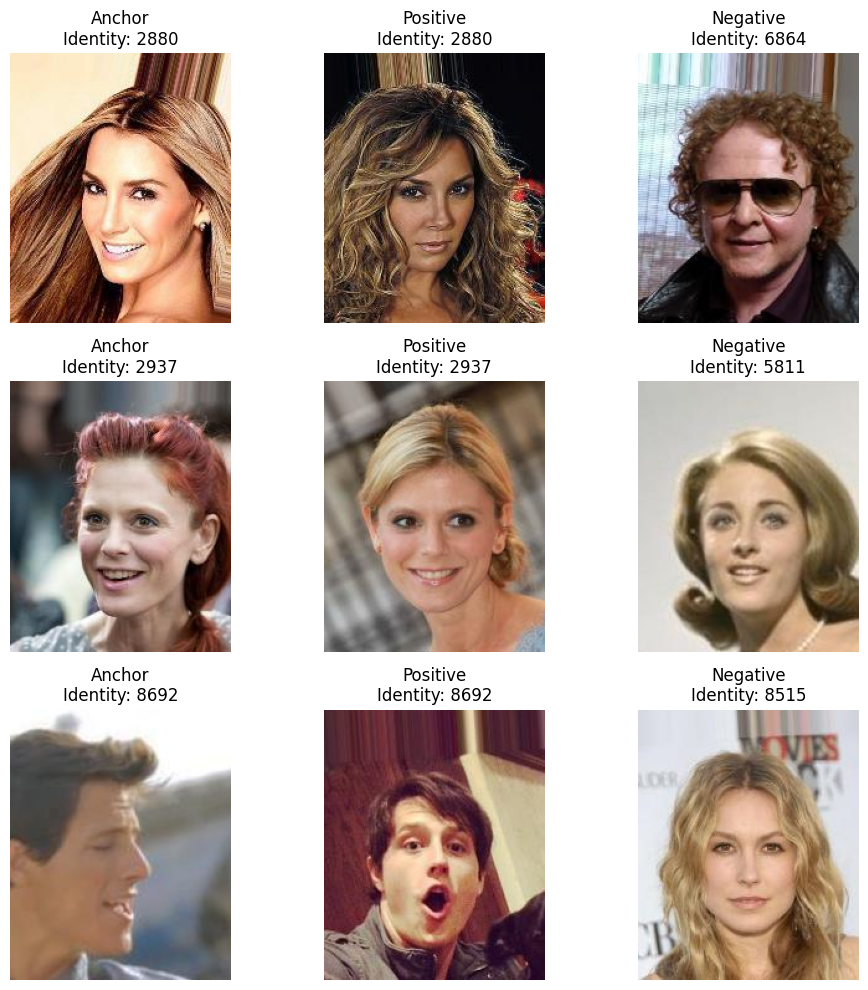

In [99]:
# A triplet batch is (Images, Labels) x (Anchor, Positive, Negative) x Batch Size x Channels x Height x Width
# = 16 x 2 x 3 x 3 x 218 x 178

def example(n=1):
    idx = train_triplet_sampler[next(example_iter)]
    triplet = train_triplet_dataset[idx]
    print(f"Train Dataset Size: {len(train_triplet_dataset)} - Total Batches: {len(train_triplet_dl)} of {train_triplet_dl.batch_size}")
    print("Train batch shape:", end=" ")
    print(train_triplet_dl.batch_size, len(triplet), len(triplet[0]), len(triplet[0][0]), *triplet[0][0][0].shape, sep=' x ')
    print(f"Validation Dataset Size: {len(val_triplet_dataset)} - Total Batches: {len(val_triplet_dl)} of {val_triplet_dl.batch_size}")
    triplets = [triplet]

    for _ in range(n-1):
        idx = train_triplet_sampler[next(example_iter)]
        triplets.append(train_triplet_dataset[idx])
    
    plot_triplets(triplets)

example(3)

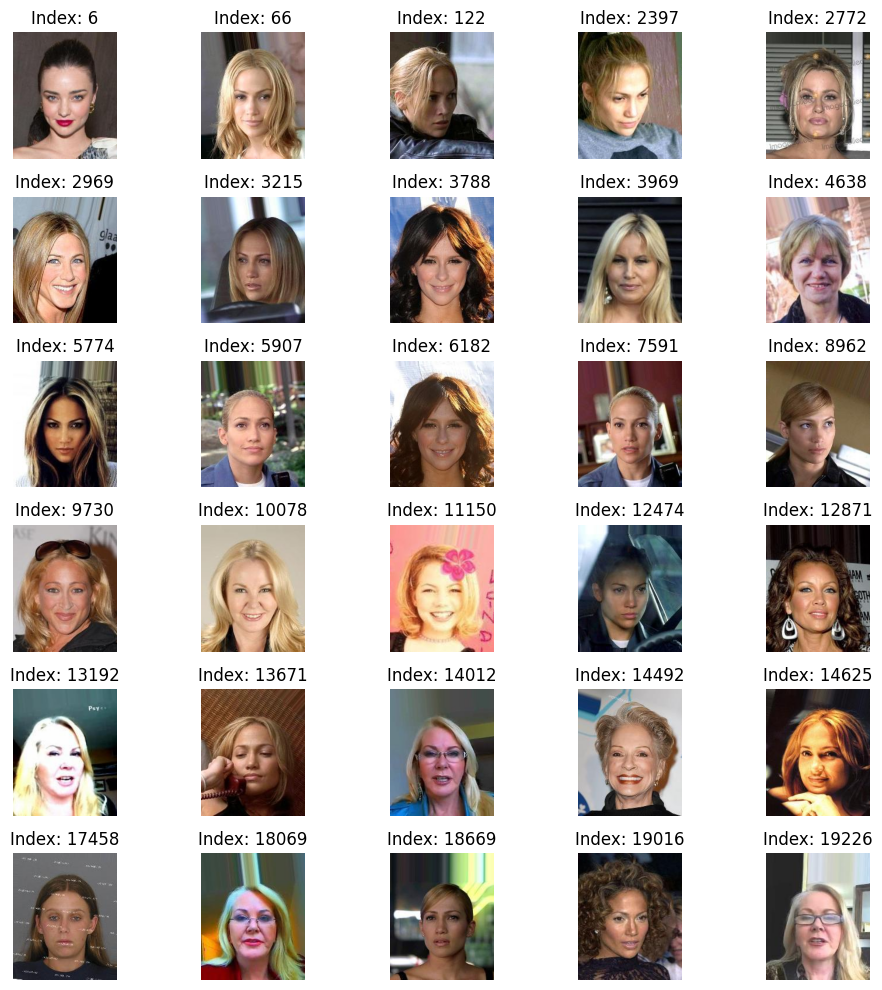

In [100]:
def show_identity_images(id, columns=5):
    dataset = celeba_valid
    idxs = np.where(dataset.identity == id)[0]
    if len(idxs) == 0: 
        print("No images with that identity")
        return
    rows = math.ceil(len(idxs)/columns)
    fig, ax = plt.subplots(rows, columns, figsize=(10, 10))
    for i in range(columns*rows):
        if i < len(idxs):
            ax[i//columns, i%columns].imshow(dataset[idxs[i]][0].permute(1, 2, 0))
            ax[i//columns, i%columns].set_title(f"Index: {idxs[i]}")
        ax[i//columns, i%columns].axis('off')
        
    plt.tight_layout()
    plt.show()


show_identity_images(4441, 5)
# show_identity_images(1298, 5)

### CNN class and functions for training, validation and show results and predictions

In [145]:
class TripletNet(nn.Module):
    def __init__(self):
        super(TripletNet, self).__init__()
        self.resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        self.resnet.fc = nn.Identity() # Override last layer of resnet to replace with our own fc layers
        # add 2 fc
        self.fc = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
        )

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)


    def forward(self, anchor, positive, negative):
        anchor = self.resnet(anchor)
        anchor = self.fc(anchor)
        positive = self.resnet(positive)
        positive = self.fc(positive)
        negative = self.resnet(negative)
        negative = self.fc(negative)
        return anchor, positive, negative


def train_triplet_net(triplet_net, 
                      train_triplet_dl,
                      val_triplet_dl,
                      criterion,
                      optimizer,
                      lr_scheduler,
                      epochs=1, 
                      num_batches=None,
                      num_val_batches=None,
                      freeze=False, 
                      batches_summary=250,
                      verbose=True):
    
    train_loss_history = []
    val_loss_history = []
    val_acc_history = []

    if num_batches is None: num_batches = len(train_triplet_dl)
    if batches_summary is None: batches_summary = num_batches
    if num_batches < batches_summary: print(f"Warning: num_batches ({num_batches}) < batches_summary ({batches_summary})")

    print_stats = lambda: print(f"Epoch: {epoch + 1}, Batch: {batch_i + 1}",
                                f"Train Loss: {round(running_loss / batches_summary, 3)}",
                                f"Val Loss: {round(val_loss, 3)}",
                                f"Val Accuracy: {round(val_acc, 3)}", 
                                end='\n' if verbose else '\r')
                                # f"Train Accuracy: {correct_preds / (batches_summary * triplet_data_loader.batch_size)}"
    
    for param in triplet_net.resnet.parameters():
        param.requires_grad = not freeze
    triplet_net.fc.requires_grad = True

    # criterion = nn.TripletMarginLoss(margin=1.0, p=2)
    
    triplet_net.train()

    try:
        for epoch in range(epochs):
            running_loss = 0.0
            for batch_i, triplet_batch in enumerate(train_triplet_dl):
                anchor, positive, negative = triplet_batch[0]
                # TODO: load to cuda only once?
                anchor, positive, negative = triplet_net(anchor.cuda(), positive.cuda(), negative.cuda())
                loss = criterion(anchor, positive, negative)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
                lr_scheduler.step()
                running_loss += loss.item()

                if batch_i % batches_summary == batches_summary - 1:
                    print("Validating...      ", end='\r')
                    val_loss, val_acc = val_triplet_net(triplet_net, val_triplet_dl, criterion, batches=num_val_batches)
                    print("", end='\r')
                    val_loss_history.append(val_loss)
                    val_acc_history.append(val_acc)
                    train_loss_history.append(running_loss / batches_summary)
                    print_stats()
                    running_loss = 0.0
                else:
                    print(f"Train Loss: {round(loss.item(), 3)}", end='\r')


                if batch_i == num_batches - 1: # Skip to next epoch
                    # print("Validating...", end='\r')
                    # val_loss, val_acc = val_triplet_net(triplet_net, val_triplet_dl, criterion, batches=num_val_batches)
                    # print("", end='\r')
                    # print_stats()
                    # print()
                    break

    except KeyboardInterrupt:
        print("\nKeyboard Interrupt. Final stats:\n")
        val_loss, val_acc = val_triplet_net(triplet_net, val_triplet_dl, criterion, verbose=0)
        print_stats()
        
    print("Finished Training\n")
    return train_loss_history, val_loss_history, val_acc_history, batches_summary




def val_triplet_net(triplet_net, triplet_data_loader, criterion, verbose=0, batches=None):
    bs = triplet_data_loader.batch_size
    total_samples = len(triplet_data_loader.dataset)
    # bs, total_samples = 64, 19862
    running_loss = 0.0
    correct_predictions = 0
    samples_done = 0

    triplet_net.eval()
    with torch.no_grad():
        for i, triplet_batch in enumerate(triplet_data_loader):
            if i == batches: break
            anchor, positive, negative = triplet_batch[0]
            anchor, positive, negative = triplet_net(anchor.cuda(), positive.cuda(), negative.cuda())
            running_loss += criterion(anchor, positive, negative).item() * len(anchor)
            anchor, positive, negative = anchor.cpu(), positive.cpu(), negative.cpu()
            samples_done += len(anchor)
            for j in range(len(anchor)):
                anchor_pos_dist = np.linalg.norm(anchor[j] - positive[j])
                anchor_neg_dist = np.linalg.norm(anchor[j] - negative[j])
                closest = np.argmin([anchor_neg_dist, anchor_pos_dist])
                correct_predictions += closest
                if verbose == 2:
                    print("Anchor Positive Distance:", anchor_pos_dist)
                    print("Anchor Negative Distance:", anchor_neg_dist)
                    print("Closest:", ["Negative", "Positive"][closest])
                    
        # samples_done = min((i+1)*bs, total_samples)
        accuracy = correct_predictions / samples_done
        val_loss = running_loss / samples_done
        if verbose >= 1:
            print(f"Val Loss: {val_loss:.3f}, Val Accuracy: {accuracy:.3f} ({correct_predictions}/{samples_done})")
        if verbose == 2: print()

        triplet_net.train()
        return val_loss, accuracy



def visualize_results(train_loss_history, val_loss_history, val_acc_history, batches_summary):
    if type(batches_summary) == np.ndarray: batches_summary = batches_summary[0]
    assert len(train_loss_history) == len(val_loss_history) == len(val_acc_history), "Unequal history lengths"
    x_axis = np.arange(batches_summary, len(train_loss_history)*batches_summary+1, batches_summary)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].plot(x_axis, train_loss_history, label="Train Loss")
    ax[0].plot(x_axis, val_loss_history, label="Val Loss")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Batches")
    ax[0].legend()
    ax[1].plot(x_axis, val_acc_history)
    ax[1].set_title("Accuracy")
    ax[1].set_xlabel("Batches")
    plt.show()



def show_predictions(triplet_net, triplet_data_loader, num_correct=2, num_incorrect=2):
    cur_correct = 0
    cur_incorrect = 0
    triplet_net.eval()
    with torch.no_grad():
        for i, triplet_batch in enumerate(triplet_data_loader):
            anchor_img, positive_img, negative_img = triplet_batch[0]
            anchors, positives, negatives = triplet_net(anchor_img.cuda(), positive_img.cuda(), negative_img.cuda())
            anchors, positives, negatives = anchors.cpu(), positives.cpu(), negatives.cpu()
            for j in range(len(anchors)):
                anchor_pos_dist = np.linalg.norm(anchors[j] - positives[j])
                anchor_neg_dist = np.linalg.norm(anchors[j] - negatives[j])
                if anchor_pos_dist < anchor_neg_dist:
                    if cur_correct < num_correct:
                        plot_triplets([[(anchor_img[j], positive_img[j], negative_img[j]), 
                                        [triplet_batch[1][0][j], triplet_batch[1][1][j], triplet_batch[1][2][j]]]])
                        cur_correct += 1
                else:
                    if cur_incorrect < num_incorrect:
                        plot_triplets([[(anchor_img[j], positive_img[j], negative_img[j]),
                                        [triplet_batch[1][0][j], triplet_batch[1][1][j], triplet_batch[1][2][j]]]])
                        cur_incorrect += 1
                if cur_correct == num_correct and cur_incorrect == num_incorrect:
                    return



### Create CNN and run training, validation, show results and predictions

In [146]:
triplet_net = TripletNet()
triplet_net.cuda()

history = []

loss_fn = nn.TripletMarginLoss(margin=1.0, p=2)
optimizer = optim.Adam(triplet_net.parameters(), lr=0.001)
lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=1, total_iters=100) # Constant for now

In [147]:
print("Initial validation loss and accuracy:")
loss, acc = val_triplet_net(triplet_net, val_triplet_dl, loss_fn, batches=50, verbose=1)
np.append(history[1], loss)
np.append(history[2], acc)

Val Loss: 0.745, Val Accuracy: 0.674 (2157/3200)


(0.7447620987892151, 0.6740625)

In [158]:
lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01, total_iters=3000)

In [165]:
new_history = train_triplet_net(triplet_net,
                                train_triplet_dl,
                                val_triplet_dl,
                                loss_fn,
                                optimizer,
                                lr_scheduler,
                                freeze=True,
                                epochs=1,
                                num_batches=3000,
                                num_val_batches=30,
                                batches_summary=500)

override = False
# override = True
history = new_history if override or not history else [np.append(h1, h2) for h1, h2 in zip(history, new_history)]

Epoch: 1, Batch: 500 Train Loss: 0.329 Val Loss: 0.306 Val Accuracy: 0.871
Epoch: 1, Batch: 1000 Train Loss: 0.309 Val Loss: 0.334 Val Accuracy: 0.867
Epoch: 1, Batch: 1500 Train Loss: 0.319 Val Loss: 0.328 Val Accuracy: 0.859
Epoch: 1, Batch: 2000 Train Loss: 0.322 Val Loss: 0.327 Val Accuracy: 0.868
Epoch: 1, Batch: 2500 Train Loss: 0.325 Val Loss: 0.326 Val Accuracy: 0.861
Epoch: 1, Batch: 3000 Train Loss: 0.316 Val Loss: 0.329 Val Accuracy: 0.862
Finished Training



In [166]:
loss, acc = val_triplet_net(triplet_net, val_triplet_dl, loss_fn, batches=None, verbose=False)
np.append(history[1], loss)
np.append(history[2], acc)
print(f"Validation Loss: {round(loss, 3)}\nValidation Accuracy: {round(acc, 3)}")

Validation Loss: 0.325
Validation Accuracy: 0.862


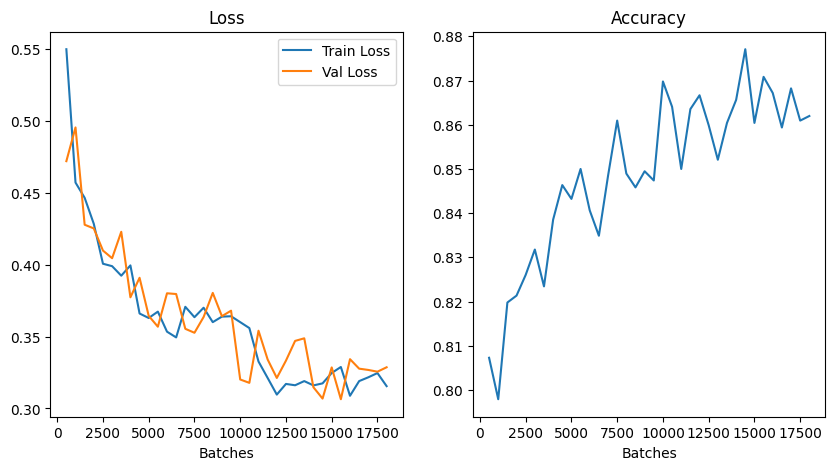

In [167]:
visualize_results(*history)

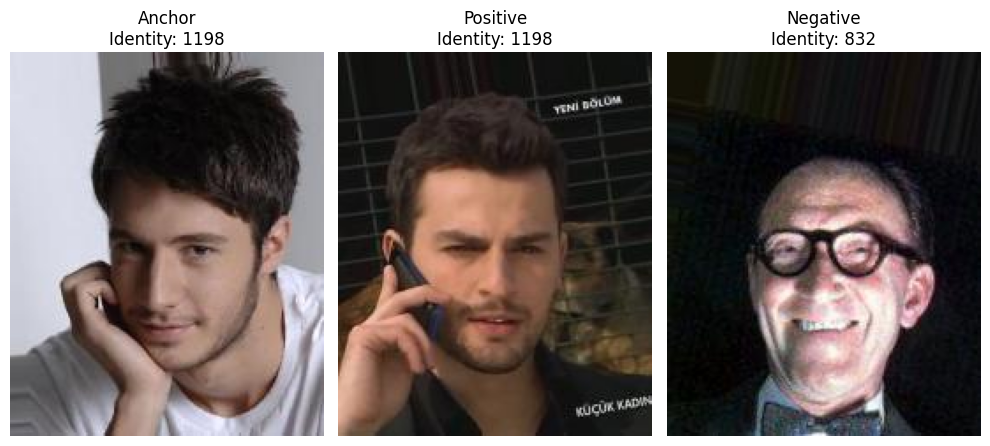

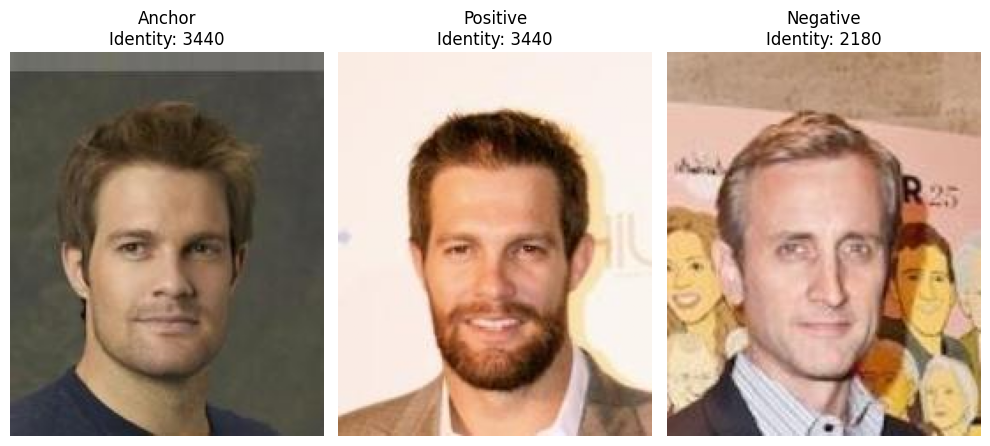

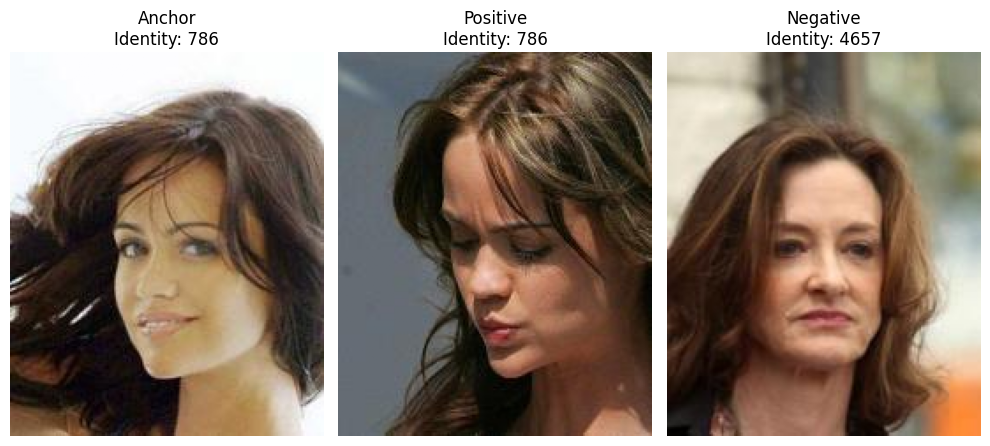

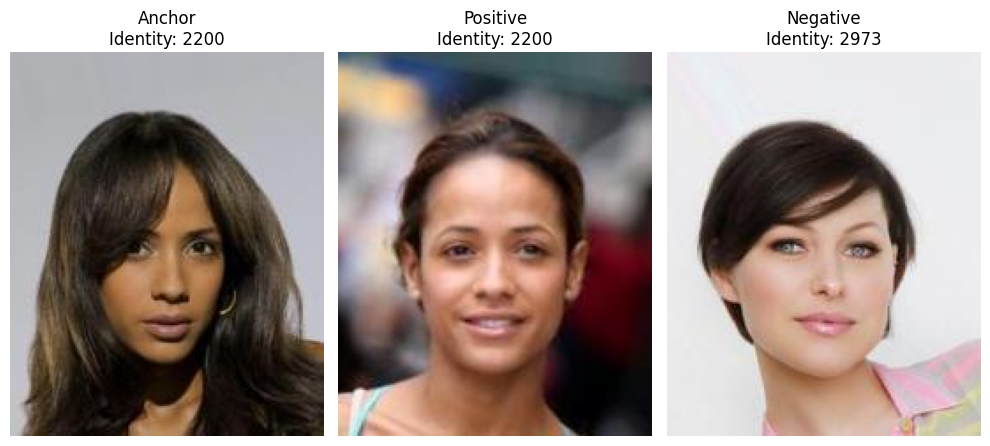

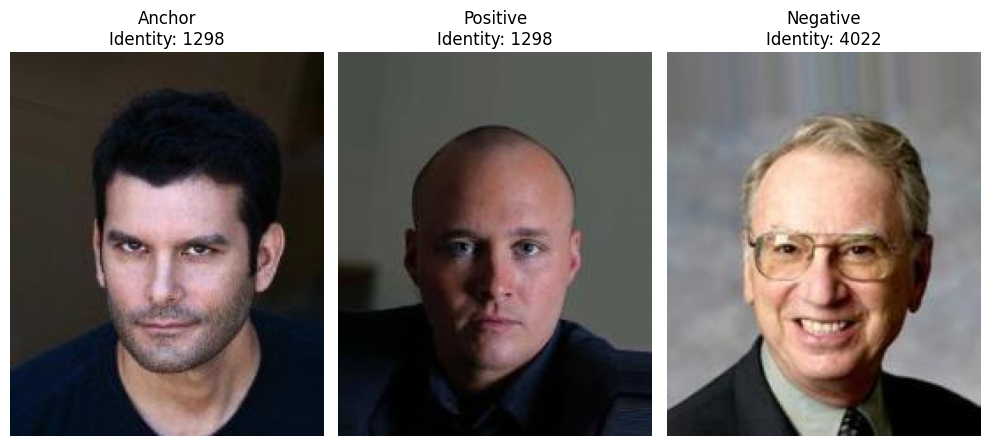

In [117]:
show_predictions(triplet_net, val_triplet_dl, num_correct=0, num_incorrect=5)

### Save and load model and result history

In [61]:
checkpoint = {
    "model": triplet_net.state_dict(),
    "optimizer": optimizer.state_dict(),
    "lr_scheduler": lr_scheduler.state_dict(),
    "history": history,
}
torch.save(checkpoint, "models/triplet_net3.pt")

In [64]:
checkpoint = torch.load("models/triplet_net3.pt")
triplet_net.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])
lr_scheduler.load_state_dict(checkpoint["lr_scheduler"])
history = checkpoint["history"]

### Other random stuff

In [ ]:
# Show the embeddings of the all images of the first 10 people

# get all images of the first 10 people
first_10_idx = torch.where(celeba_train.identity <= 10)[0]

# get all embeddings of triplet_net of the first 10 people
first_10_embeddings = []
# first_10_imgs = []
for batch_i in first_10_idx:
    img, label = celeba_train[batch_i]
    # first_10_imgs.append(img)
    img = img.cuda()
    img = img.unsqueeze(0)
    embedding = triplet_net.resnet(img)
    first_10_embeddings.append(embedding)

first_10_labels = celeba_train.identity[first_10_idx].numpy()

# find first image of each of the first 10 people
first_10_imgs = []
for batch_i in range(1,11):
    idx = torch.where(celeba_train.identity == batch_i)[0][0]
    img, label = celeba_train[idx]
    first_10_imgs.append(img)

# show one image of each of the first 10 people
fig, ax = plt.subplots(1, 10, figsize=(20, 20))
for batch_i, img in enumerate(first_10_imgs):
    ax[batch_i].imshow(img.permute(1, 2, 0))
    ax[batch_i].set_title(f"Identity: {batch_i + 1}")
    ax[batch_i].axis('off')
plt.show()

# plot the embeddings of the first 10 people
first_10_embeddings = torch.stack(first_10_embeddings)
first_10_embeddings = first_10_embeddings.squeeze(1)
first_10_embeddings = first_10_embeddings.cpu().detach().numpy()
plt.scatter(first_10_embeddings[:, 0], first_10_embeddings[:, 1], c=first_10_labels)
plt.show()

# print identity with lowest and largest embedding value
max_idx = np.argmax(first_10_embeddings[:, 0])
print("Identity with largest embedding value:")
print(first_10_labels[max_idx])
min_idx = np.argmin(first_10_embeddings[:, 0])
print("Identity with lowest embedding value:")
print(first_10_labels[min_idx])

# Show the embeddings of the first 10 people with TSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
first_10_embeddings_tsne = tsne.fit_transform(first_10_embeddings)
# show legend with 10 identities
plt.legend([f"Identity: {i + 1}" for i in range(10)])
plt.scatter(first_10_embeddings_tsne[:, 0], first_10_embeddings_tsne[:, 1], c=first_10_labels, cmap='tab10')
plt.show()

# print identity with lowest and largest TNES value
max_idx = np.argmax(first_10_embeddings_tsne[:, 0])
print("Identity with largest TNES value:")
print(first_10_labels[max_idx])
min_idx = np.argmin(first_10_embeddings_tsne[:, 0])
print("Identity with lowest TNES value:")
print(first_10_labels[min_idx])


### 3.5 Training function (fit) (PROVIDED BY HENRIK)

The code below can be used to train a model and monitor important stats as training progresses. The training is carried out by calling the `fit` function, which takes any model as input.

You can change the optimizer by replacing `base_optimizer` with your own function handle.

The function `base_lr_scheduler` is a learning rate scheduler that updates the learning rate of the optimizer during training. The dummy-implementation does nothing, but you can modify it to implement your own learning rate scheduler. The inputs are
- `T` : Total number of batches
- `t` : Current batch index (max(t) = T)
- `lr` : Current learning rate

Other parameters to `fit` are:
- `bs` the batch size
- `epochs` the number of epochs
- `batches_per_epoch` the number of batches per epoch. If set to `None`, all images in the dataset are used.

Note that you can use `batches_per_epoch` to reduce the size of the training set. The effective size of the training set is `bs*batches_per_epoch`.

In [ ]:
from torch import optim

# Function handle that returns an optimizer
def base_optimizer(model,lr=0.001, momentum=0.9):
    return optim.SGD(model.parameters(), lr=lr,momentum=momentum)

# Function handle that updates the learning rate
# (note this is a dummy implementation that does nothing)
def base_lr_scheduler(t,T,lr):
  return lr

# Function to fit a model
def fit(model,
        opt_func=base_optimizer, # Inject own optimizer here
        lr_scheduler=base_lr_scheduler, # Inject own scheduler here
        bs=256,
        epochs=1,
        batches_per_epoch=None, # Default: Use entire training set
        show_summary=True):

  # Set up data loaders
  if batches_per_epoch == None:
    # Use all images
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs,
                                          shuffle=True, num_workers=2)
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs,
                                         shuffle=False, num_workers=2)
    batches_per_epoch = len(train_dl)
  else:
    # Only use a subset of the data
    subset_indices = list(range(batches_per_epoch*bs))
    train_dl = torch.utils.data.DataLoader(trainset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

    # Use one fourth for validation
    subset_indices = list(range(int(np.ceil(batches_per_epoch/4))*bs))
    valid_dl = torch.utils.data.DataLoader(testset, batch_size=bs, sampler=torch.utils.data.sampler.SubsetRandomSampler(subset_indices), num_workers=2)

  # Initialize optimizer
  opt = opt_func(model)

  # For book keeping
  train_loss_history = []
  valid_loss_history = []
  plot_time_train = []
  plot_time_valid = []

  # Index of current batch
  t = 1

  # Total number of batches
  T = batches_per_epoch * epochs

  print('Epochs:',epochs,'Batches per epoch:',batches_per_epoch,'Total number of batches',T)

  # Get initial validation loss and accuracy
  model.eval()
  with torch.no_grad():
    valid_acc = sum(accuracy(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
    valid_loss = sum(loss_func(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
    valid_loss_history.append(valid_loss.detach().cpu().numpy())
    plot_time_valid.append(t)

  # Train
  for epoch in range(epochs):
    model.train() # Train mode
    for xb, yb in train_dl:

      # Update learning rate
      opt.param_groups[0]['lr'] = lr_scheduler(t,T,lr=opt.param_groups[0]['lr'])

      # Forward prop
      pred = model(xb.cuda())
      loss = loss_func(pred, yb.cuda())

      # Book keeping
      train_loss_history.append(loss.detach().cpu().numpy())
      plot_time_train.append(t)
      t += 1

      # Backward prop (calculate gradient)
      loss.backward()

      # Update model parameters
      opt.step()
      opt.zero_grad()

      # Validation loss and accuracy
      if t % 10 == 0:    # print every 10 mini-batches
        model.eval() # Test mode
        with torch.no_grad():
            valid_acc = sum(accuracy(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
            valid_loss = sum(loss_func(model(xb.cuda()), yb.cuda()) for xb, yb in valid_dl) / len(valid_dl)
            valid_loss_history.append(valid_loss.detach().cpu().numpy())
            plot_time_valid.append(t-1)
            print('t',t,'lr',opt.param_groups[0]['lr'],'train loss',loss.detach().cpu().numpy(), 'val loss',valid_loss.detach().cpu().numpy(),'val accuracy', valid_acc.detach().cpu().numpy())
        model.train() # Back to train mode

  # Summary
  if show_summary:
    plt.figure()
    lines = []
    labels = []
    l, = plt.plot(plot_time_train,train_loss_history)
    lines.append(l)
    labels.append('Training')
    print(valid_loss_history)
    l, = plt.plot(plot_time_valid,valid_loss_history)
    lines.append(l)
    labels.append('Validation')
    plt.title('Loss')
    plt.legend(lines, labels, loc=(1, 0), prop=dict(size=14))
    plt.show()

  return train_loss_history



In [ ]:
# Generic function to train a model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Copy weights
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history only if in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# Generic function to display predictions for a few images
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(2, num_images//2, images_so_far)
                ax.axis('off')
                ax.set_title('pred/true: {}/{}'.format(class_names[preds[j]],
                                                       class_names[labels[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

### Trash

In [ ]:
# # Get a random anchor image and its identity
# _, anchor_identity = self.dataset[i]
# # Get all indexes with the same identity
# same_identity_idx = torch.where(self.dataset.identity == anchor_identity)[0]
# # remove the anchor image from the list
# same_identity_idx = same_identity_idx[same_identity_idx != i]
# # Get a random positive image
# positive_idx = same_identity_idx[torch.randint(len(same_identity_idx), (1,))]
# # Get all indexes with different identities
# different_identity_idx = torch.where(self.dataset.identity != anchor_identity)[0]
# # Get a random negative image
# negative_idx = different_identity_idx[torch.randint(len(different_identity_idx), (1,))]




# triplet_batch = next(triplet_iter)
# imgs = [triplet_batch[0][0][0], triplet_batch[0][1][0], triplet_batch[0][2][0]]
# labels = [triplet_batch[1][0][0], triplet_batch[1][1][0], triplet_batch[1][2][0]]
# plot_triplet(imgs, labels)




# triplet_net.eval()
# with torch.no_grad():
#     accuracies = []
#     for i, triplet_batch in enumerate(triplet_data_loader):
#         correct_predictions = 0
#         anchor, positive, negative = triplet_batch[0]
#         anchor, positive, negative = anchor.cuda(), positive.cuda(), negative.cuda()
#         anchor, positive, negative = triplet_net(anchor, positive, negative)
#         anchor, positive, negative = anchor.cpu(), positive.cpu(), negative.cpu()
#         for j in range(anchor.shape[0]):
#             anchor_pos_dist = np.linalg.norm(anchor[j] - positive[j])
#             anchor_neg_dist = np.linalg.norm(anchor[j] - negative[j])
#             closest = np.argmin([anchor_neg_dist, anchor_pos_dist])
#             correct_predictions += closest
#             if verbose:
#                 print("Anchor Positive Distance:", anchor_pos_dist)
#                 print("Anchor Negative Distance:", anchor_neg_dist)
#                 print("Closest:", ["Negative", "Positive"][closest])
#                 print()
#         accuracy = correct_predictions / anchor.shape[0]
#         print(f"Batch: {i + 1}, Accuracy: {accuracy} ({correct_predictions}/{anchor.shape[0]})")
#         accuracies.append(accuracy)

#         if i == batches-1:
#             print(f"\nTotal Accuracy: {sum(accuracies) / len(accuracies)}")
#             break



# ...

# Epoch: 1, Batch: 500 Train Loss: 0.82 Val Loss: 0.503 Val Accuracy: 0.772
# Epoch: 1, Batch: 1000 Train Loss: 0.904 Val Loss: 1.013 Val Accuracy: 0.551
# Epoch: 1, Batch: 1500 Train Loss: 0.935 Val Loss: 0.814 Val Accuracy: 0.609
# Epoch: 1, Batch: 2000 Train Loss: 0.82 Val Loss: 0.788 Val Accuracy: 0.644
# Epoch: 1, Batch: 2500 Train Loss: 0.78 Val Loss: 0.752 Val Accuracy: 0.657
# Epoch: 1, Batch: 3000 Train Loss: 0.752 Val Loss: 0.755 Val Accuracy: 0.665
# Finished Training

# Epoch: 1, Batch: 500 Train Loss: 0.507 Val Loss: 0.51 Val Accuracy: 0.77
# Epoch: 1, Batch: 1000 Train Loss: 0.685 Val Loss: 0.56 Val Accuracy: 0.748
# Epoch: 1, Batch: 1500 Train Loss: 0.562 Val Loss: 0.478 Val Accuracy: 0.781
# Epoch: 1, Batch: 2000 Train Loss: 0.491 Val Loss: 0.433 Val Accuracy: 0.806
# Epoch: 1, Batch: 2500 Train Loss: 0.467 Val Loss: 0.522 Val Accuracy: 0.769
# Epoch: 1, Batch: 3000 Train Loss: 0.437 Val Loss: 0.393 Val Accuracy: 0.816
# Finished Training

# Epoch: 1, Batch: 500 Train Loss: 0.33 Val Loss: 0.422 Val Accuracy: 0.806
# Epoch: 1, Batch: 1000 Train Loss: 0.443 Val Loss: 0.411 Val Accuracy: 0.808
# Epoch: 1, Batch: 1500 Train Loss: 0.393 Val Loss: 0.395 Val Accuracy: 0.818
# Epoch: 1, Batch: 2000 Train Loss: 0.408 Val Loss: 0.365 Val Accuracy: 0.838
# Epoch: 1, Batch: 2500 Train Loss: 0.39 Val Loss: 0.344 Val Accuracy: 0.843
# Epoch: 1, Batch: 3000 Train Loss: 0.372 Val Loss: 0.385 Val Accuracy: 0.82
# Finished Training

# Epoch: 1, Batch: 500 Train Loss: 0.264 Val Loss: 0.347 Val Accuracy: 0.84
# Epoch: 1, Batch: 1000 Train Loss: 0.369 Val Loss: 0.369 Val Accuracy: 0.838
# Epoch: 1, Batch: 1500 Train Loss: 0.366 Val Loss: 0.325 Val Accuracy: 0.851
# Epoch: 1, Batch: 2000 Train Loss: 0.349 Val Loss: 0.351 Val Accuracy: 0.843
# Epoch: 1, Batch: 2500 Train Loss: 0.34 Val Loss: 0.326 Val Accuracy: 0.849
# Epoch: 1, Batch: 3000 Train Loss: 0.333 Val Loss: 0.31 Val Accuracy: 0.858
# Finished Training